In [2]:
%autoreload 2

In [3]:
from collections import defaultdict
from argparse import Namespace
import copy
import gzip
import itertools
import math
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import duckdb
from IPython.display import display, Markdown, HTML  # type: ignore
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from Levenshtein import distance as _edit_distance
import numpy as np
import pandas as pd
import tabulate
import tatsu
import tatsu.ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tabulate
from tqdm.notebook import tqdm
from scipy import stats
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import _extract_game_id, deepcopy_ast, replace_child
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *

2023-10-03 12:39:57 - ast_utils - DEBUG    - Using cache folder: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache
2023-10-03 12:39:57 - src.ast_utils - DEBUG    - Using cache folder: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache


In [4]:

grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
# regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
# print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


2023-10-03 12:40:04 - ast_utils - INFO     - Loading from cache file: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache/interactive-beta-cache.pkl.gz
2023-10-03 12:40:04 - ast_utils - INFO     - Finished loading cache file: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache/interactive-beta-cache.pkl.gz


In [5]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_prop,variables_used_all,variables_used_prop,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1.0,1,1.0,...,0.968048,0.979128,0.968876,0.979584,0.980420,0.982740,0.919068,0.960887,0.998712,1.000000
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1.0,1,1.0,...,0.973823,0.978192,0.965107,0.976486,0.975603,0.983432,0.899002,0.914971,0.965387,0.974323
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1.0,1,1.0,...,0.945618,0.972216,0.000000,0.000000,0.000000,0.000000,0.850539,0.904462,0.948491,0.957243
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1.0,1,1.0,...,0.986638,0.980074,0.000000,0.000000,0.000000,0.000000,0.919068,0.960887,0.998712,1.000000
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1.0,1,1.0,...,0.982992,0.979321,0.000000,0.000000,0.000000,0.000000,0.964519,0.971914,0.973287,0.964638


In [6]:
postprocessor = ast_parser.ASTSamplePostprocessor()
postprocessed_real_game_texts = [ast_printer.ast_to_string(postprocessor(ast), '\n') for ast in game_asts]  # type: ignore

real_game_edit_distances = np.zeros((len(game_asts), len(game_asts)), dtype=int)
for i, j in itertools.combinations(range(len(game_asts)), 2):
    real_game_edit_distances[i, j] = real_game_edit_distances[j, i] = edit_distance(postprocessed_real_game_texts[i], postprocessed_real_game_texts[j])


def edit_distance(first_game_text: str, second_game_text: str):
    first_game_text = first_game_text[first_game_text.find(')', first_game_text.find('(:domain')) + 1:]
    second_game_text = second_game_text[second_game_text.find(')', second_game_text.find('(:domain')) + 1:]
    return _edit_distance(first_game_text, second_game_text)


def find_nearest_real_game_indices(game, k: int = 3) -> typing.Tuple[np.ndarray, np.ndarray]:
    game_str = ast_printer.ast_to_string(game, '\n')
    distances = np.array([edit_distance(game_str, real_game) for real_game in postprocessed_real_game_texts])
    nearest_real_game_indices = np.argsort(distances)[:k]
    return nearest_real_game_indices, distances[nearest_real_game_indices]


def print_nearest_real_games(game, k: int = 3):
    indices, distances = find_nearest_real_game_indices(game, k)
    for i, (idx, d) in enumerate(zip(indices, distances)):
        real_game_distances = real_game_edit_distances[idx]
        nearest_distance_indices = np.argsort(real_game_distances)[1:k + 1]  # index 0 is the game itself
        display(Markdown(f'### Nearest real game #{i + 1}:'))
        display(Markdown(f'Edit distance to sample {d}, real game nearest neighbor distances {np.array2string(real_game_distances[nearest_distance_indices], separator=", ")}):\n'))
        display(Markdown(f'```pddl\n{real_game_texts[idx]}\n```'))


In [7]:
HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS = dict(hspace=0.3)


def plot_value_histograms(results_by_feature_name_and_value: typing.Dict[str, typing.Dict[int, typing.List[float]]],
    bins: int = 20, histogram_log_y: bool = False, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    k = len(results_by_feature_name_and_value.keys())

    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    for i, feature_name in enumerate(results_by_feature_name_and_value.keys()):
        if layout[0] == 1:
            ax = axes[i]
        else:
            ax = axes[i // layout[1]][i % layout[1]]

        values_with = results_by_feature_name_and_value[feature_name][1]
        values_without = results_by_feature_name_and_value[feature_name][0]

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([values_with, values_without], label=[f'1 (n={len(values_with)})', f'0 (n={len(values_without)})'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Fitness value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title = f'#{i + 1}: {feature_name}'
        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()


def analyze_archive_fullness(model: MAPElitesSampler, mutually_exclusive_features: typing.Optional[typing.List[str]] = None,
                             plot_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):
    if plot_kwargs is None:
        plot_kwargs = {}
    
    results_by_feature_name = {feature_name: defaultdict(list) for feature_name in model.map_elites_feature_names}
    results_by_feature_count = defaultdict(list)

    for key, fitness_value in model.fitness_values.items():
        for feature_name, feature_value in model._key_to_feature_dict(key).items():
            results_by_feature_name[feature_name][feature_value].append(fitness_value)

        if isinstance(key, int):
            key_bits = count_set_bits(key)
        else:
            key_bits = sum(k != 0 for k in key)

        results_by_feature_count[key_bits].append(fitness_value)

    display(Markdown(f'## Archive fullness analysis'))
    display(Markdown(f'Ttoal of {len(model.fitness_values)} samples in archive, {len(model.map_elites_feature_names)} features'))
    display(Markdown(f'### Results by feature'))
    lines = []
    for feature_name, results in results_by_feature_name.items():
        lines.append(f'- {feature_name}:')
        for feature_value in sorted(results.keys()):
            value_results = results[feature_value]
            lines.append(f'    - ={feature_value}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)})')

    display(Markdown('\n'.join(lines)))

    display(Markdown(f'### Results by set feature count'))
    lines = []
    for feature_count in sorted(results_by_feature_count.keys()):
        value_results = results_by_feature_count[feature_count]
        lines.append(f'- set-count={feature_count}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)} / {math.comb(len(model.map_elites_feature_names), feature_count)})')

    display(Markdown('\n'.join(lines)))

    plot_value_histograms(results_by_feature_name, **plot_kwargs)


In [8]:
SUBPLOTS_ADJUST_PARAMS = dict(top=0.925)
DEFAULT_IGNORE_METRICS = ['Timestamp']

def plot_sampler_fitness_trajectory(
        evo: PopulationBasedSampler, title: typing.Optional[str] = None, 
        axsize: typing.Tuple[int, int] = (8, 6),
        plot_metrics: typing.Optional[bool] = None, 
        ignore_metrics: typing.Optional[typing.List[str]] = DEFAULT_IGNORE_METRICS,
        subplots_adjust_params: typing.Dict[str, float] = SUBPLOTS_ADJUST_PARAMS,
        min_real_game_fitness: float = 57.9193, max_real_game_fitness: float = 62.9249): 

    if plot_metrics is None:
        plot_metrics = hasattr(evo, 'archive_metrics_history') and len(evo.archive_metrics_history) > 0  # type: ignore

    if ignore_metrics is None:
        ignore_metrics = []
            
    layout = (1, 2) if plot_metrics else (1, 1)
    figsize = (axsize[0] * layout[1], axsize[1])

    fig, axes = plt.subplots(*layout, figsize=figsize)

    mean, max_fit, std = [], [], []
    for step_dict in evo.fitness_metrics_history:
        mean.append(step_dict['mean'])
        max_fit.append(step_dict['max'])
        std.append(step_dict['std'])

    mean = np.array(mean)
    max_fit = np.array(max_fit)
    std = np.array(std)

    fitness_ax = typing.cast(matplotlib.axes.Axes, axes[0] if plot_metrics else axes)

    fitness_ax.plot(mean, label='mean fitness')
    fitness_ax.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2, label='std')  # type; ignore
    fitness_ax.plot(max_fit, label='max fitness')

    fitness_ax.hlines(min_real_game_fitness, 0, len(mean), label='min real game fitness', color='black', ls='--')
    fitness_ax.hlines(max_real_game_fitness, 0, len(mean), label='max real game fitness', color='black', ls='--')

    fitness_ax.set_xlabel('Generation')
    fitness_ax.set_ylabel('Fitness')

    fitness_ax.legend(loc='best')
    
    if plot_metrics:
        metrics = {key: [] for key in evo.archive_metrics_history[0].keys() if key not in ignore_metrics}  # type: ignore
        for step_dict in evo.archive_metrics_history:  # type: ignore
            for key, value in step_dict.items():
                if key in metrics:
                    metrics[key].append(value)

        metrics_ax = typing.cast(matplotlib.axes.Axes, axes[1])
        for key, values in metrics.items():
            metrics_ax.plot(values, label=key)

        metrics_ax.set_xlabel('Generation')
        metrics_ax.set_ylabel('Metric Value')

        metrics_ax.legend(loc='best')

        plt.subplots_adjust(**subplots_adjust_params)
        
    if title is not None:
        if plot_metrics:
            plt.suptitle(title)
        else:
            plt.title(title)

    plt.show()


def count_games_above_fitness_threshold(evo: PopulationBasedSampler, threshold: float) -> int:
    if isinstance(evo.fitness_values, dict):
        fitness_values = evo.fitness_values.values()
    else:
        fitness_values = evo.fitness_values

    return sum(1 for fitness in fitness_values if fitness >= threshold)

In [10]:
REPRESENTATIVE_GAME_INDICES = [26, 58, 42, 31, 48, 19, 14, 62, 93] 

WARNING_YELLOW_BG_COLOR = '#F1EB9C'

GAME_INDEX = 0
GAME_AST = 1
GAME_FITNESS = 2
GAME_KEY = 3
SAMPLE_FITNESS = 4
SAMPLE_AST = 5


CUSTOM_BACKGROUND_COLOR_CLASSES = ('bg-info', 'bg-warning', 'bg-success', 'bg-danger', 'bg-primary', 'bg-secondary', 'bg-dark', 'bg-light')


def _format_ast_for_html(ast, line_delimiter='<br>', increment='  ',):
    return f'<pre><code>{ast_printer.ast_to_string(ast, line_delimiter, increment=increment)}</code></pre>'


def make_representative_game_table(model: MAPElitesSampler, trace_filter_data: typing.Optional[typing.Dict[str, typing.Any]] = None,
                                   representative_game_indices=REPRESENTATIVE_GAME_INDICES, 
                                   real_game_asts=game_asts, line_delimiter='<br>', increment='  ', tablefmt='unsafehtml'):
    real_game_fitness_scores = [model._score_proposal(game, return_features=False) for game in real_game_asts]
    real_game_fitness_score_indices = np.argsort(real_game_fitness_scores)[::-1]  # type: ignore
    
    rows = [[] for _ in range(6)]

    for idx in representative_game_indices:
        real_game_rank = np.where(real_game_fitness_score_indices == idx)[0][0]
        rows[GAME_INDEX].append(f'Game #{idx} (fitness rank {real_game_rank})')

        real_game_ast_str = _format_ast_for_html(real_game_asts[idx], line_delimiter=line_delimiter, increment=increment)
        rows[GAME_AST].append(real_game_ast_str)

        fitness = real_game_fitness_scores[idx]
        rows[GAME_FITNESS].append(f'<strong>Real game fitness: {fitness:.4f}</<strong>')

        real_game = real_game_asts[idx]
        real_game_key = model._features_to_key(real_game, model._proposal_to_features(real_game))
        key_dict = model._key_to_feature_dict(real_game_key)
        key_dict_str = '<br>'.join([f'<strong>Key {real_game_key}:</strong>'] + [f'{feature_name}: {feature_value}' for feature_name, feature_value in key_dict.items()])
        rows[GAME_KEY].append(key_dict_str)

        if real_game_key in model.population:
            sample = model.population[real_game_key]
            sample_fitness = model._score_proposal(sample, return_features=False)
            custom_class = 'placeholder'
            postfix = ''

            if trace_filter_data is not None and real_game_key in trace_filter_data['summary']:
                sample_trace_filter_result = trace_filter_data['summary'][real_game_key]
                postfix = f' (trace filter result: {sample_trace_filter_result})'
                
                if sample_trace_filter_result == -1:
                    custom_class = 'bg-info'
                
                elif sample_trace_filter_result == 0:
                    custom_class = 'bg-warning'

                else:
                    custom_class = 'bg-success'

            rows[SAMPLE_FITNESS].append(f'<div class="{custom_class}"><strong>Sample fitness: {sample_fitness:.4f}{postfix}</strong></div>')

            sample_ast_str = _format_ast_for_html(sample, line_delimiter=line_delimiter, increment=increment)
            rows[SAMPLE_AST].append(sample_ast_str)

        else:
            rows[SAMPLE_FITNESS].append('No sample found')
            rows[SAMPLE_AST].append('N/A')

    return tabulate.tabulate(rows, headers='firstrow', tablefmt=tablefmt)


def make_representative_game_table_to_html(table_html: str, model_name: str, real_game_energy_range: typing.Tuple[float, float], output_path='representative_games.html'):
    table_html = table_html.replace('<table>', '<table class="table table-striped table-bordered">')
    table_html = table_html.replace('<thead>', '<thead class="thead-dark">')
    table_html = table_html.replace('<th>', '<th scope="col">')
    for custom_class in CUSTOM_BACKGROUND_COLOR_CLASSES:
        table_html = table_html.replace(f'<td><div class="{custom_class}">', f'<td class="{custom_class}"><div>')
    
    style = """
    <style>
        .table td, .table th {
            min-width: 40em;
            max-width: 60em;
        }
        pre {
            white-space: pre-wrap;
            max-height: 60em;
            overflow: auto;
            display: inline-block;
        }
    </style>
    """

    html_template = f"""
    <html lang="en">
    <head>
        <meta charset="utf-8">
        <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
        <title>Representative games comparison</title>
        <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@4.0.0/dist/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous">
        {style}
    </head>
    <body>
        <div>
            <h1>Representative games comparison for {model_name}</h1>
            <h3>Real game energy range: min: {real_game_energy_range[0]:.4f}, max: {real_game_energy_range[1]:.4f}</h3>
            Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
            {table_html}
        </div>
        <script src="https://code.jquery.com/jquery-3.2.1.slim.min.js" integrity="sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN" crossorigin="anonymous"></script>
        <script src="https://cdn.jsdelivr.net/npm/popper.js@1.12.9/dist/umd/popper.min.js" integrity="sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q" crossorigin="anonymous"></script>
        <script src="https://cdn.jsdelivr.net/npm/bootstrap@4.0.0/dist/js/bootstrap.min.js" integrity="sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl" crossorigin="anonymous"></script>
    </body>
    """

    with open(output_path, 'w') as f:
        f.write(html_template)


def make_and_save_representative_game_table(model, model_name, real_game_energy_range: typing.Tuple[float, float],
                                            trace_filter_data: typing.Optional[typing.Dict[str, typing.Any]] = None,
                                            representative_game_indices=REPRESENTATIVE_GAME_INDICES, 
                                            real_game_asts=game_asts, line_delimiter='<br>', increment='  ', tablefmt='unsafehtml'):
    table_html = make_representative_game_table(model, trace_filter_data, representative_game_indices, real_game_asts, line_delimiter, increment, tablefmt)
    output_path = f'./output_htmls/representative_games_{model.output_name}_{datetime.now().strftime("%Y_%m_%d")}.html'
    print(f'Saving representative games table to {os.path.abspath(output_path)}')
    make_representative_game_table_to_html(table_html, model_name, real_game_energy_range, output_path)


def plot_fitness_trajectory_and_make_game_table(model: MAPElitesSampler, title: str):
    min_real_game_fitness =  -1 * model.fitness_function.score_dict['max']
    max_real_game_fitness = -1 * model.fitness_function.score_dict['min']
    plot_sampler_fitness_trajectory(model, title, min_real_game_fitness=min_real_game_fitness, 
                                    max_real_game_fitness=max_real_game_fitness)
    make_and_save_representative_game_table(model, title, (min_real_game_fitness, max_real_game_fitness))


In [11]:
FITNESS_COMPARISON_SCATTER_KWARGS = dict()
FITNESS_COMPARISON_LINE_KWARGS = dict()
FITNESS_COMPARISON_SUBPLOT_ADJUST_KWARGS = dict(hspace=0.3, wspace=0.1)


def plot_fitness_comparison_across_bins(
    models: typing.List[MAPElitesSampler],
    real_game_bins_only: bool = True,
    real_game_asts: typing.List[tuple] = game_asts,  # type: ignore
    n_rows: typing.Optional[int] = None,
    n_cols: typing.Optional[int] = None,
    color_by_margin: bool = True,
    underperforming_bin_threshold: int = 2,
    color_in_margin: str = 'purple',
    color_outside_margin: str = 'orange',
    width_per_bin: float = 2,
    height_per_bin: float = 2.5,
    baseline_fontsize: int = 8,
    scatter_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = FITNESS_COMPARISON_SCATTER_KWARGS,
    line_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = FITNESS_COMPARISON_LINE_KWARGS,
    subplot_adjust_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = FITNESS_COMPARISON_SUBPLOT_ADJUST_KWARGS, 
):
    if scatter_kwargs is None:
        scatter_kwargs = {}

    if line_kwargs is None:
        line_kwargs = {}

    if subplot_adjust_kwargs is None:
        subplot_adjust_kwargs = {}
    
    real_game_fitness_scores, real_game_features = zip(*[models[0]._score_proposal(game, return_features=True) for game in real_game_asts])  # type: ignore
    real_game_iqr = np.percentile(real_game_fitness_scores, 75) - np.percentile(real_game_fitness_scores, 25)
    real_game_keys = [models[0]._features_to_key(game, features) for game, features in zip(real_game_asts, real_game_features)]
    bins_to_real_game_indices = defaultdict(list)
    for idx, real_game_key in enumerate(real_game_keys):
        bins_to_real_game_indices[real_game_key].append(idx)

    if real_game_bins_only:
        n_bins = len(bins_to_real_game_indices)
        bins = list(sorted(bins_to_real_game_indices.keys()))
        
    else:
        n_bins_by_model = [len(model.population) for model in models]
        max_poulation_model_index = np.argmax(n_bins_by_model)
        n_bins = n_bins_by_model[max_poulation_model_index]
        bins = list(sorted(models[max_poulation_model_index].population.keys()))

    if n_rows is not None and n_cols is not None:
        assert n_rows * n_cols >= n_bins, f'Not enough rows and columns to fit {n_bins} bins'
    elif n_rows is not None:
        n_cols = math.ceil(n_bins / n_rows)
    elif n_cols is not None:
        n_rows = math.ceil(n_bins / n_cols)
    else:
        n_cols = math.ceil(math.sqrt(n_bins))
        n_rows = math.ceil(n_bins / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * width_per_bin, n_rows * height_per_bin))

    underperforming_bins = []

    for bin_idx, bin_key in enumerate(bins):
        ax = axes[bin_idx // n_cols, bin_idx % n_cols]
        title = f'({",".join([str(x) for x in bin_key])})' if isinstance(bin_key, tuple) else str(bin_key)
        
        ax.set_yticks([])
        ax.tick_params(axis='both', which='major', labelsize=baseline_fontsize)
        ax.tick_params(axis='both', which='minor', labelsize=baseline_fontsize - 2)

        bin_fitness_values = [model.fitness_values[bin_key] for model in models]
        
        max_real_game_bin_fitness = None
        if bin_key in bins_to_real_game_indices:
            max_real_game_bin_fitness = max(real_game_fitness_scores[real_game_index] for real_game_index in bins_to_real_game_indices[bin_key])
            for real_game_index in bins_to_real_game_indices[bin_key]:
                real_game_fitness = real_game_fitness_scores[real_game_index]
                ax.axvline(real_game_fitness, alpha=0.75 if real_game_fitness == max_real_game_bin_fitness else 0.25, **line_kwargs)

        if color_by_margin and max_real_game_bin_fitness is not None:
            # iqr_count = len([fitness for fitness in bin_fitness_values if fitness >= max_real_game_bin_fitness - real_game_iqr])
            # title += f' (IQR: {iqr_count}/{len(bin_fitness_values)})'
            games_within_margin = [fitness >= max_real_game_bin_fitness - real_game_iqr for fitness in bin_fitness_values]
            if len(games_within_margin) - sum(games_within_margin) >= underperforming_bin_threshold:
                underperforming_bins.append(bin_key)

            c =  [color_in_margin if within_margin else color_outside_margin for within_margin in games_within_margin]
        else:
            c = color_outside_margin

        ax.scatter(bin_fitness_values, np.arange(1, len(models) + 1), c=c, **scatter_kwargs)

        ax.set_title(title, fontsize=baseline_fontsize + 2)

    x_mins, x_maxes = zip(*[axes[bin_idx // n_cols, bin_idx % n_cols].get_xlim() for bin_idx in range(len(bins))])
    x_min = min(x_mins)
    x_max = max(x_maxes)
    for ax in axes.flatten():
        ax.set_xlim(x_min, x_max)

    for spare_bin_idx in range(len(bins), n_rows * n_cols):
        ax = axes[spare_bin_idx // n_cols, spare_bin_idx % n_cols]
        ax.axis('off')

    plt.subplots_adjust(**subplot_adjust_kwargs)
    plt.show()
    return underperforming_bins

2023-10-03 12:41:10 - compile_predicate_statistics_full_database - INFO     - Loading data from files
2023-10-03 12:41:31 - compile_predicate_statistics_full_database - INFO     - Creating DuckDB table...
2023-10-03 12:41:33 - compile_predicate_statistics_full_database - INFO     - Creating data table indices...
2023-10-03 12:42:09 - compile_predicate_statistics_full_database - INFO     - Loaded data, found 840475 rows


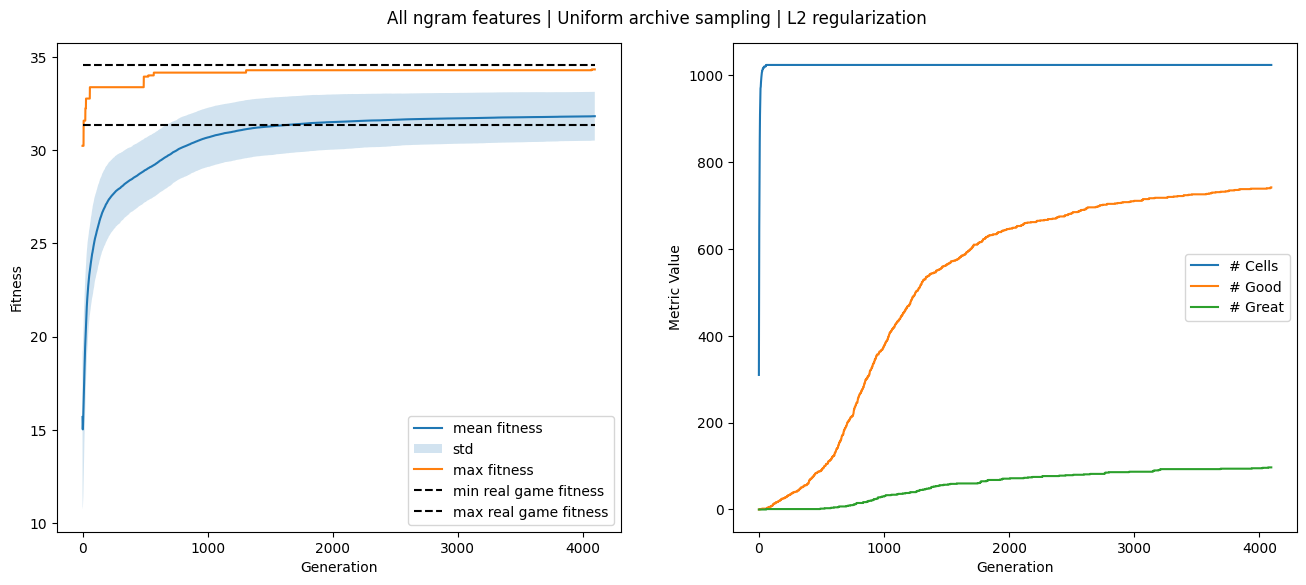

Saving representative games table to /home/gd1279/projects/game-generation-modeling/notebooks/output_htmls/representative_games_map_elites_minimal_counting_grammar_use_forall_L2_log_queries_latest_setup_uniform_seed_42_2023_10_03.html


In [12]:
models, names = [], []




all_ngrams_uniform_l2_model = typing.cast(MAPElitesSampler, utils.load_data('', 'samples', 'map_elites_minimal_counting_grammar_use_forall_L2_log_queries_latest_setup_uniform_seed_42_final_2023_10_03'))
all_ngrams_uniform_l2_name = 'All ngram features | Uniform archive sampling | L2 regularization'
plot_fitness_trajectory_and_make_game_table(all_ngrams_uniform_l2_model, all_ngrams_uniform_l2_name)
models.append(all_ngrams_uniform_l2_model)
names.append(all_ngrams_uniform_l2_name)

# all_ngrams_fitness_rank_l2_model = typing.cast(MAPElitesSampler, utils.load_data('', 'samples', 'map_elites_minimal_counting_grammar_use_forall_L2_experimental_setup_fitness_rank_seed_42_final_2023_09_27'))
# all_ngrams_fitness_rank_l2_name = 'All ngram features | Fitness rank archive sampling | L2 regularization'
# plot_fitness_trajectory_and_make_game_table(all_ngrams_fitness_rank_l2_model, all_ngrams_fitness_rank_l2_name)
# models.append(all_ngrams_fitness_rank_l2_model)
# names.append(all_ngrams_fitness_rank_l2_name)

# full_ngram_only_uniform_l2_model = typing.cast(MAPElitesSampler, utils.load_data('', 'samples', 'map_elites_minimal_counting_grammar_use_forall_full_ngram_only_L2_experimental_setup_uniform_seed_42_final_2023_09_27'))
# full_ngram_only_uniform_l2_name = 'Full ngram feature only | Uniform archive sampling | L2 regularization'
# plot_fitness_trajectory_and_make_game_table(full_ngram_only_uniform_l2_model, full_ngram_only_uniform_l2_name)
# models.append(full_ngram_only_uniform_l2_model)
# names.append(full_ngram_only_uniform_l2_name)

# full_ngram_only_fitness_rank_l2_model = typing.cast(MAPElitesSampler, utils.load_data('', 'samples', 'map_elites_minimal_counting_grammar_use_forall_full_ngram_only_L2_experimental_setup_fitness_rank_seed_42_final_2023_09_27'))
# full_ngram_only_fitness_rank_l2_name = 'Full ngram feature only | Fitness rank archive sampling | L2 regularization'
# plot_fitness_trajectory_and_make_game_table(full_ngram_only_fitness_rank_l2_model, full_ngram_only_fitness_rank_l2_name)
# models.append(full_ngram_only_fitness_rank_l2_model)
# names.append(full_ngram_only_fitness_rank_l2_name)

In [20]:
from src.evolutionary_sampler_behavioral_features import EXPECTED_FEATURE_VALUES, ExpectedFeatureValuesBehavioralFeature

model = all_ngrams_uniform_l2_model
results = []
feature = ExpectedFeatureValuesBehavioralFeature()


for key, game in model.population.items():
    feature.game_start()
    features = model._proposal_to_features(game)
    feature.parse_full_features(features)
    features_with_wrong_value = [feature for feature, expected_value in EXPECTED_FEATURE_VALUES.items() if features[feature] != expected_value]

    results.append((key, model.fitness_values[key], feature.game_end(), features_with_wrong_value))


results = sorted(results, key=lambda x: len(x[-1]), reverse=False)

results[:10]


[((0, 0, 0, 0, 0, 1, 0, 0, 0, 1), 31.393232345581055, True, []),
 ((1, 0, 0, 1, 0, 0, 0, 0, 0, 1), 34.1531867980957, True, []),
 ((1, 0, 0, 0, 1, 0, 0, 0, 0, 1), 33.212642669677734, True, []),
 ((1, 0, 0, 0, 0, 1, 0, 0, 0, 1), 33.98563766479492, True, []),
 ((0, 0, 0, 0, 0, 1, 1, 0, 0, 1), 30.040063858032227, True, []),
 ((1, 0, 0, 0, 0, 0, 0, 0, 0, 1), 28.196147918701172, True, []),
 ((0, 1, 0, 0, 0, 1, 0, 0, 0, 1), 33.02784729003906, True, []),
 ((0, 1, 0, 1, 0, 0, 0, 0, 0, 1), 29.563020706176758, True, []),
 ((0, 0, 1, 0, 0, 1, 1, 0, 0, 1), 31.388126373291016, True, []),
 ((1, 0, 0, 0, 0, 0, 0, 1, 0, 1), 33.741477966308594, True, [])]

In [21]:
results[-10:]


[((1, 0, 0, 1, 1, 0, 0, 1, 1, 1),
  32.76861572265625,
  False,
  ['disjoint_preferences_scoring_terminal_types',
   'disjoint_preferences_same_predicates_only']),
 ((1, 0, 1, 1, 1, 1, 0, 1, 1, 1),
  32.327903747558594,
  False,
  ['disjoint_preferences_scoring_terminal_types',
   'disjoint_preferences_same_predicates_only']),
 ((1, 0, 1, 0, 1, 1, 1, 0, 1, 1),
  32.28279113769531,
  False,
  ['disjoint_preferences_scoring_terminal_types',
   'disjoint_preferences_same_predicates_only']),
 ((1, 0, 0, 0, 1, 0, 1, 1, 1, 0),
  32.32730484008789,
  False,
  ['disjoint_preferences_scoring_terminal_types',
   'disjoint_preferences_same_predicates_only']),
 ((1, 0, 0, 1, 1, 0, 1, 0, 1, 1),
  32.792999267578125,
  False,
  ['disjoint_preferences_scoring_terminal_types',
   'disjoint_preferences_same_predicates_only']),
 ((1, 0, 0, 1, 0, 1, 1, 0, 1, 0),
  31.78369140625,
  False,
  ['disjoint_preferences_scoring_terminal_types',
   'disjoint_preferences_same_predicates_only']),
 ((0, 1, 0, 0, 1,

In [13]:
table_model_indices = [0,] #  2]
table_models = [models[idx] for idx in table_model_indices]
table_names = [names[idx] for idx in table_model_indices]

use_absolute_values = False

weights_by_model = {}
weight_ranks_by_model = {}

for model, name in zip(table_models, table_names):
    model_weights = model.fitness_function.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
    if use_absolute_values:
        model_weights = torch.abs(model_weights)
    model_weights_rank = stats.rankdata(model_weights.numpy())
    if use_absolute_values:
        model_weights_rank = len(model_weights_rank) - model_weights_rank + 1
    weights_by_model[name] = {model.feature_names[i]: model_weights[i].item() for i in range(len(model.feature_names))}
    weight_ranks_by_model[name] = {model.feature_names[i]: model_weights_rank[i] for i in range(len(model.feature_names))}


feature_mean_rank = {
    feature_name: np.mean([weights[feature_name] for weights in weight_ranks_by_model.values()])
    for feature_name in weights_by_model[table_names[0]].keys()
}

feature_names_by_mean_rank = sorted(feature_mean_rank.keys(), key=lambda feature_name: feature_mean_rank[feature_name], reverse=False)

headers = ['Feature', 'Mean Rank'] + table_names
rows = [[feature_name, f'{feature_mean_rank[feature_name]:.3f}'] + [f'{weights_by_model[name][feature_name]:.3f} ({int(weight_ranks_by_model[name][feature_name])})'   
                          for name in table_names] 
        for feature_name in feature_names_by_mean_rank]

# with open('temp_outputs/features_by_mean_weight.tsv', 'w') as f:
#     f.write(tabulate.tabulate(rows, headers, tablefmt='tsv'))

print(tabulate.tabulate(rows, headers, tablefmt='fancy_grid'))


╒════════════════════════════════════════════════════════════╤═════════════╤═════════════════════════════════════════════════════════════════════╕
│ Feature                                                    │   Mean Rank │ All ngram features | Uniform archive sampling | L2 regularization   │
╞════════════════════════════════════════════════════════════╪═════════════╪═════════════════════════════════════════════════════════════════════╡
│ ast_ngram_full_n_5_score                                   │           1 │ -12.087 (1)                                                         │
├────────────────────────────────────────────────────────────┼─────────────┼─────────────────────────────────────────────────────────────────────┤
│ ast_ngram_constraints_n_5_score                            │           2 │ -8.047 (2)                                                          │
├────────────────────────────────────────────────────────────┼─────────────┼──────────────────────────────────────────

In [ ]:
# def compute_pairwise_edit_distances(model: MAPElitesSampler):
#     population_as_strings = {key: ast_printer.ast_to_string(ast) for key, ast in tqdm(model.population.items(), desc='Stringifying population')}  # type: ignore
#     population_keys = list(model.population.keys())
#     distances = []
#     total_combinations = len(population_keys) * (len(population_keys) - 1) / 2
#     for first_key, second_key in tqdm(itertools.combinations(population_keys, 2), desc='Computing pairwise distances', total=total_combinations):
#         distances.append(_edit_distance(population_as_strings[first_key], population_as_strings[second_key]))

#     return np.mean(distances), np.std(distances), np.std(distances) / np.sqrt(total_combinations), len(population_as_strings), len(distances)
        

# model_edit_distances = {model.output_name: compute_pairwise_edit_distances(model) for model in models}

# for name, distances in model_edit_distances.items():
#     print(f'{name}: {distances}')

In [ ]:
# specific_object_model_edit_distances = {model.output_name: compute_pairwise_edit_distances(model) for model in specific_object_models}

# for name, distances in specific_object_model_edit_distances.items():
#     print(f'{name}: {distances}')

In [ ]:
# def compute_pairwise_feature_distances(model: MAPElitesSampler, ord: int = 1):
#     population_as_features = {key: model._proposal_to_features(ast) for key, ast in tqdm(model.population.items(), desc='Featurizing population')}  # type: ignore
#     population_as_features = {key: np.array([features[n] for n in model.feature_names], dtype=float) for key, features in population_as_features.items()}
#     population_keys = list(model.population.keys())
#     distances = []
#     total_combinations = len(population_keys) * (len(population_keys) - 1) / 2
#     for first_key, second_key in tqdm(itertools.combinations(population_keys, 2), desc='Computing pairwise distances', total=total_combinations):
#         distances.append(np.linalg.norm(population_as_features[first_key] - population_as_features[second_key], ord=ord))

#     return np.mean(distances), np.std(distances), np.std(distances) / np.sqrt(total_combinations), len(population_as_features), len(distances)
        

# model_edit_distances = {model.output_name: compute_pairwise_feature_distances(model) for model in models}

# for name, distances in model_edit_distances.items():
#     print(f'{name}: {distances}')

In [ ]:
# specific_object_model_edit_distances = {model.output_name: compute_pairwise_feature_distances(model) for model in specific_object_models}

# for name, distances in specific_object_model_edit_distances.items():
#     print(f'{name}: {distances}')

In [ ]:
# # models = [
# #     predicate_and_object_groups_seed_33, 
# #     predicate_and_object_groups_seed_42,
# #     predicate_and_object_groups_seed_66, 
# #     predicate_and_object_groups_seed_99
# # ]


# real_game_fitness_scores, real_game_features = zip(*[models[0]._score_proposal(game, return_features=True) for game in game_asts])  # type: ignore
# real_game_keys = [models[0]._features_to_key(game, features) for game, features in zip(game_asts, real_game_features)]  # type: ignore
# bins_to_real_game_indices = defaultdict(list)
# for idx, real_game_key in enumerate(real_game_keys):
#     bins_to_real_game_indices[real_game_key].append(idx)


# # n_bins_by_model = [len(model.population) for model in models]
# # max_poulation_model_index = np.argmax(n_bins_by_model)
# # n_bins = n_bins_by_model[max_poulation_model_index]
# # all_bins = list(sorted(models[max_poulation_model_index].population.keys()))

# # scores_with_human_games = []
# # scores_without_human_games = []

# # for bin in all_bins:
# #     target_list = scores_with_human_games if bin in bins_to_real_game_indices else scores_without_human_games
# #     for model in models:
# #         target_list.append(model.fitness_values[bin])

# # print('With human games:', np.mean(scores_with_human_games), np.std(scores_with_human_games))
# # print('Without human games:', np.mean(scores_without_human_games), np.std(scores_without_human_games))
# # ttest_result = stats.ttest_ind(scores_with_human_games, scores_without_human_games)
# # print('T-test:', ttest_result)


# underperforming_bins = plot_fitness_comparison_across_bins(models, n_cols=7)
# print(underperforming_bins)

In [ ]:
# headers = ['Underperforming Bins'] + [f'#{i + 1}' for i in range(len(underperforming_bins))] + ['Sum', 'Overall Count', '%']

# underperforming_feature_counts = {}
# overall_feature_counts = {}

# rows = []
# for i, feature_name in enumerate(models[0].map_elites_feature_names):
#     underperforming_bin_values = [bin[i] for bin in underperforming_bins]
#     underperforming_feature_counts[feature_name] = sum(underperforming_bin_values)
#     overall_feature_counts[feature_name] = sum([bin[i] for bin in bins_to_real_game_indices.keys()])

#     proportion = f'{underperforming_feature_counts[feature_name] / overall_feature_counts[feature_name]:.2f}'
#     row = [feature_name.replace('|', ' OR ')] + underperforming_bin_values + [underperforming_feature_counts[feature_name], overall_feature_counts[feature_name], proportion]
#     rows.append(row)
    


# table = tabulate.tabulate(rows, headers=headers, tablefmt='github')

# display(Markdown(table))

In [ ]:


# for bin in underperforming_bins:
#     models[0].print_key_features(bin)
#     for game_index in bins_to_real_game_indices[bin]:
#         ast = game_asts[game_index]
#         ast_str = ast_printer.ast_to_string(ast, '\n')
#         display(Markdown(f'```pddl\n{ast_str}\n```\n'))
        

In [ ]:
# model = evo_sampler_map_elites_fitness_rank_no_at_end
model = all_ngrams_uniform_l2_model
index = 3
n_features_on = None
feature_keywords_to_print = None  # ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3
key_features = None  # dict(section_doesnt_exist_setup=0)

key = model.visualize_top_sample(index, feature_keywords_to_print=feature_keywords_to_print, n_features_on=n_features_on, 
    postprocess_sample=True, features=key_features)
sample = model.population[key] 
# print_nearest_real_games(sample, n_similar_real_games_to_print)

In [ ]:
model = all_ngrams_uniform_l2_model
key =   (1, 1, 1, 1, 1, 0, 0, 0, 0, 0)
n_features_on = None
feature_keywords_to_print = None  # ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3
key_features = None  # dict(section_doesnt_exist_setup=0)

key = model._visualize_sample_by_key(key, feature_keywords_to_print=feature_keywords_to_print, postprocess_sample=True)
sample = model.population[key] 

In [ ]:
values = list(model.fitness_values.values())
plt.hist(values, bins=50)

In [ ]:
game = model.postprocessor(sample)
game_fitness, game_features = model._score_proposal(game, return_features=True)
{k: v for k, v in game_features.items() if 'preferences' in k}

In [ ]:
edited_game_str = """
(define (game evo-2481-238-1) (:domain few-objects-room-v1)
(:setup
  (and
    (exists (?v0 - hexagonal_bin)
      (game-conserved
        (< (distance floor ?v0) 1)
     )
   )
 )
)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - beachball ?v1 - hexagonal_bin)
        (then
          (once (and (adjacent ?v1 agent) (agent_holds ?v0)))
          (hold (and (in_motion ?v0) (not (agent_holds ?v0 ) ) ))
          (once (and (not (in_motion ?v0)) (in ?v1 ?v0)))
       )
     )
   )
 )
)
(:terminal
  (or
    (>= (count preference0) 1)
 )
)
(:scoring
  (count preference0)
)
)
""".strip()
game = model.postprocessor(sample)
game_fitness, game_features = model._score_proposal(game, return_features=True)
game_features_tensor = model._features_to_tensor(game_features)

edited_game = grammar_parser.parse(edited_game_str)
edited_game_fitness, edited_game_features = model._score_proposal(edited_game, return_features=True)
edited_game_features_tensor = model._features_to_tensor(edited_game_features)
print(edited_game_fitness)

for key in game_features:
    if edited_game_features[key] != game_features[key]:
        print(key, game_features[key], edited_game_features[key])



utils.evaluate_comparison_energy_contributions(
    game_features_tensor, edited_game_features_tensor,
    ast_printer.ast_to_string(game, '\n'), edited_game_str,
    model.fitness_function, model.feature_names,
)

In [ ]:
print(ast_printer.ast_to_string(sample, '\n'))

In [ ]:
print(ast_printer.ast_to_string(model._gen_regrowth_sample(sample, model.rng), '\n'))

In [ ]:
s1 = '(preference preference1  (exists (?v0 - (either golfball dodgeball) ?v1 - hexagonal_bin)    (at-end      (in ?v1 ?v0)   ) ))'
s2 = '(preference preference0  (exists (?v0 - (either golfball dodgeball) ?v1 - hexagonal_bin)    (at-end      (in ?v1 ?v0)   ) ))'
strs = [s1, s2]
cleaned_strs = []

for s in strs:
    pref_index = s.index('(preference')
    space_index = s.index(' ', pref_index)
    space_after_pref_name_index = s.index(' ', space_index + 1)
    pref_without_name = s[space_after_pref_name_index:]
    cleaned_strs.append(pref_without_name)

print(len(set(cleaned_strs)))
print(cleaned_strs)


In [ ]:
model = fitness_rank_predicates

def real_games_to_keys(map_elites_sampler: MAPElitesSampler, real_asts: typing.List[tatsu.ast.AST]) -> typing.List[str]:
    return set([map_elites_sampler._features_to_key(ast, map_elites_sampler._proposal_to_features(ast)) for ast in real_asts])
    

real_game_keys = real_games_to_keys(model, game_asts)
high_quality_sample_keys = set([k for k, v in model.fitness_values.items() if v > 70])
high_quality_no_real_game_keys = high_quality_sample_keys - real_game_keys
print(len(real_game_keys), len(high_quality_sample_keys), len(real_game_keys.intersection(high_quality_sample_keys)), len(high_quality_no_real_game_keys))


high_quality_no_real_game_keys = [t[0] for t in sorted([(k, model.fitness_values[k]) for k in high_quality_sample_keys if k not in real_game_keys], key=lambda x: x[1], reverse=True)]

In [ ]:
index = 6
key = high_quality_no_real_game_keys[index]
n_features_on = None
feature_keywords_to_print = ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3 
key_features = dict(section_doesnt_exist_setup=0)

key = model._visualize_sample_by_key(key, feature_keywords_to_print=feature_keywords_to_print, postprocess_sample=True)
print_nearest_real_games(model.population[key], n_similar_real_games_to_print)

In [ ]:
def count_set_bits(n): 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for key, fitness in current_uniform.fitness_values.items():
    key_bits_to_fitness[count_set_bits(key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))

In [ ]:
threshold = 70

def count_set_bits(n):
 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for key, fitness in evo_sampler_map_elites_ucb.fitness_values.items():
    if fitness > threshold:
        key_bits_to_fitness[count_set_bits(key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))

In [ ]:
from src.evolutionary_sampler_behavioral_features import build_behavioral_features_featurizer, BASIC_BINNED, BASIC_WITH_NODE_DEPTH


featurizer = build_behavioral_features_featurizer(BASIC_WITH_NODE_DEPTH)
_ = [featurizer.parse(current_thompson.population[current_thompson.top_sample_key(i)], 'interactive-beta.pddl', return_row=False) for i in range(1, 51)]
d_generated = featurizer.to_df()
d_generated.describe()

In [ ]:
featurizer = build_behavioral_features_featurizer(BASIC_WITH_NODE_DEPTH)
_ = [featurizer.parse(game_asts[i], 'interactive-beta.pddl', return_row=False) for i in range(len(game_asts))]
d_real = featurizer.to_df()

In [ ]:
%matplotlib widget


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
generated_values = d_generated[featurizer.headers[4:-1]].values.T.astype(float)
real_values = d_real[featurizer.headers[4:-1]].values.T.astype(float)
generated_values += np.random.normal(0, 0.1, size=generated_values.shape)
real_values += np.random.normal(0, 0.1, size=real_values.shape)
ax.scatter(*real_values, s=10)
ax.scatter(*generated_values, s=10)
ax.set_xlabel('Node count')
ax.set_ylabel('# Objects')
ax.set_zlabel('# Predicates')

plt.show()

In [ ]:
fitness_df.groupby('real')[[c for c in fitness_df.columns if 'length_of_then' in c]].mean()

In [ ]:
sys.path.append('../reward-machine/')

import reward_machine_sample_filter
trace_filter = reward_machine_sample_filter.TraceFinderASTParser()

In [ ]:
for key, sample in models[1].population.items():
    traces_by_key, expected_keys = trace_filter(sample)
    if len(traces_by_key) == 0:
        if all(key not in trace_filter.preferences_or_sections_with_implemented_predicates for key in expected_keys):
            print(f'Key {key} with fitness {models[1].fitness_values[key]:.2f} has no traces because no predicates are implemented: {list(trace_filter.not_implemented_predicate_counts.keys())}')

In [ ]:
for key, sample in enumerate(game_asts):
    traces_by_key, expected_keys = trace_filter(sample)
    if len(traces_by_key) == 0:
        if all(key not in trace_filter.preferences_or_sections_with_implemented_predicates for key in expected_keys):
            print(f'Key {key} with fitness {models[1].fitness_values[key]:.2f} has no traces because no predicates are implemented: {list(trace_filter.not_implemented_predicate_counts.keys())}')
        else:
            print(f'Key {key} with fitness {models[1].fitness_values[key]:.2f} has no traces because no traces satisfy the implemented predicates: {list(trace_filter.not_implemented_predicate_counts.keys())}')


In [ ]:
import tempfile

In [ ]:
tempfile.TemporaryDirectory()